## Models Tested:
###Supervised models: LightGBM, RandomForest

###Semi-supervised models: IsolationForest, OC-SVM

###Unsupervised models: GMM, HBOS, LOF, DBSCAN

###BONUS: Manual Rules

 ### 1) Загружаются модели для классификации и поиска аномалий, настраивается единый стиль графиков и фиксируются параметры случайности и доля аномалий в данных (3%).

In [1]:
# Импорты и базовые настроки
!pip install pyod -q

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc, f1_score, accuracy_score,
    precision_score, recall_score
)

# Модели
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from pyod.models.hbos import HBOS
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler



# Визуальный стиль (единый)
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True

CONTAMINATION = 0.03
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 14.4 MB/s eta 0:00:00


###2) Определяем функции
auto_read_csv — автоматически определяет правильный разделитель и загружает CSV-файл.

rule_category — присваивает каждой строке категорию по набору логических правил (тип подозрительной активности).

build_targets — создаёт бинарную и категориальную целевые переменные на основе правил или меток в данных.

encode_features — кодирует категориальные признаки в числовые, применяя one-hot и маппинг.

time_or_random_split — делит данные на train и test по времени или случайным образом.

plot_confusion_matrix — строит тепловую карту матрицы ошибок.

plot_pr_curve — рисует precision-recall кривую и считает её AUC.

evaluate_and_print — вычисляет и выводит основные метрики классификации (accuracy, precision, recall, f1, roc_auc).

save_predictions — сохраняет результаты предсказаний в CSV-файл.

In [2]:
# Функционал
def auto_read_csv(path: str) -> pd.DataFrame:
    best = None
    for sep in [';', ',', '\t', '|']:
        try:
            df_try = pd.read_csv(path, sep=sep, encoding='utf-8')
        except Exception:
            continue
        print(f"Разделитель '{sep}' -> форма {df_try.shape}")
        if best is None or df_try.shape[1] > best.shape[1]:
            best = df_try
    if best is None:
        raise RuntimeError("Не удалось прочитать CSV.")
    print("Данные загружены:", best.shape)
    return best


def rule_category(row: pd.Series) -> str:
    v = lambda c, default=None: row.get(c, default)

    if v('channel') == 'eCommerce' and v('is_night') == 1 and v('is_3ds') == 0 and v('amount_mdl', 0) > 650:
        return 'ECOM_NIGHT_NO3DS_HIGHAMT'
    if v('geo_distance_km', 0) > 3000 and v('merchant_country') == 'MD':
        return 'IMPOSSIBLE_TRAVEL'
    if v('new_device_flag') == 1 and v('ip_risk_score', 0) >= 0.6 and v('cross_border') == 1:
        return 'NEW_DEVICE_IP_CROSS'
    if v('channel') == 'POS' and v('auth_method') == 'MAGSTRIPE' and v('is_night') == 1 and v('merchant_category') not in [None, 'Grocery', 'Home&Garden', 'Restaurants', 'Pharmacy', 'Transport/Taxi']:
        return 'POS_MAGSTRIPE_NIGHT'
    if v('merchant_country') == 'AE' and v('currency') not in [None, 'MDL', 'EUR', 'UAH', 'RON']:
        return 'RARE_COUNTRY_CCY'
    if v('txn_count_1h', 0) >= 10 or v('txn_amount_24h', 0) > 40:
        return 'VELOCITY_BURST'
    return 'NORMAL'


def build_targets(df: pd.DataFrame):
    df_cat = df.copy()
    df_cat['rule_category'] = df_cat.apply(rule_category, axis=1)

    if 'is_anomaly_ground_truth' in df.columns and df['is_anomaly_ground_truth'].notna().sum() > 0:
        y_bin = df['is_anomaly_ground_truth'].fillna(0).astype(int)
    else:
        y_bin = (df_cat['rule_category'] != 'NORMAL').astype(int)

    y_cat_rule = df_cat['rule_category'].astype('category')
    class_names = list(y_cat_rule.cat.categories)
    print("Классы (rule):", class_names)
    return y_bin, y_cat_rule


def encode_features(df: pd.DataFrame) -> pd.DataFrame:
    categorical_cols = [
        'issuer_bank', 'region', 'cluster_name_expected', 'channel',
        'merchant_category', 'merchant_country', 'currency',
        'auth_method', 'three_ds_result', 'device_type',
    ]
    existing_cols = [c for c in categorical_cols if c in df.columns]
    df_enc = pd.get_dummies(
        df,
        columns=existing_cols,
        prefix=[c.split('_')[0] for c in existing_cols],
        dtype=int
    )

    # Простые маппинги, если колонки есть
    if 'account_type' in df_enc.columns:
        df_enc['account_type'] = df_enc['account_type'].map({'Individual': 0, 'Business': 1})
    if 'card_type' in df_enc.columns:
        df_enc['card_type'] = df_enc['card_type'].map({'Debit': 0, 'Credit': 1})
    if 'product_tier' in df_enc.columns:
        tier_order = {'Standard': 0, 'Gold': 1, 'Platinum': 2}
        df_enc['product_tier'] = df_enc['product_tier'].map(tier_order)

    print("После энкодинга:", df_enc.shape)
    return df_enc.fillna(0)


def time_or_random_split(df: pd.DataFrame, X_all: pd.DataFrame, y_bin: pd.Series, test_size=0.2):
    if 'timestamp' in df.columns:
        df_sorted = df.sort_values('timestamp').reset_index(drop=True)
        cutoff = int((1 - test_size) * len(df_sorted))
        train_idx = list(range(cutoff))
        test_idx = list(range(cutoff, len(df_sorted)))
        print(f"Разделение по времени: {cutoff} train / {len(df_sorted) - cutoff} test ({cutoff/len(df_sorted):.1%} train)")
    else:
        train_idx, test_idx = train_test_split(
            np.arange(len(X_all)),
            test_size=test_size,
            random_state=RANDOM_STATE,
            stratify=y_bin if y_bin.nunique() > 1 else None
        )
        print(f"Случайное разделение: {len(train_idx)} train / {len(test_idx)} test ({len(train_idx)/len(X_all):.1%} train)")
    return train_idx, test_idx


def plot_confusion_matrix(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal', 'Predicted Anomaly'],
                yticklabels=['True Normal', 'True Anomaly'])
    plt.title(title)
    plt.xlabel("Предсказанные классы")
    plt.ylabel("Истинные классы")
    plt.tight_layout()
    plt.show()


def plot_pr_curve(y_true, scores, label_txt: str):
    precision, recall, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'{label_txt} (AUC={pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall кривая')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return pr_auc


def evaluate_and_print(y_true, y_pred, y_scores=None, model_name="Model"):
    out = {}
    # Базовые метрики
    out['accuracy'] = accuracy_score(y_true, y_pred)
    out['precision'] = precision_score(y_true, y_pred, zero_division=0)
    out['recall'] = recall_score(y_true, y_pred, zero_division=0)
    out['f1'] = f1_score(y_true, y_pred, zero_division=0)

    # ROC-AUC
    if y_scores is not None:
        try:
            out['roc_auc'] = roc_auc_score(y_true, y_scores)
        except Exception:
            out['roc_auc'] = np.nan
        # PR-AUC
        try:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            out['pr_auc'] = auc(recall, precision)
        except Exception:
            out['pr_auc'] = np.nan
    else:
        out['roc_auc'] = np.nan
        out['pr_auc'] = np.nan

    print(f"\nОценка качества: {model_name}")
    print(f"Accuracy:  {out['accuracy']:.4f}")
    print(f"Precision: {out['precision']:.4f}")
    print(f"Recall:    {out['recall']:.4f}")
    print(f"F1-score:  {out['f1']:.4f}")
    if not np.isnan(out['roc_auc']):
        print(f"ROC-AUC:   {out['roc_auc']:.4f}")
    if not np.isnan(out['pr_auc']):
        print(f"PR-AUC:    {out['pr_auc']:.4f}")

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    return out


def save_predictions(df_like: pd.DataFrame, path: str):
    df_like.to_csv(path, index=False, encoding='utf-8')
    print(f"Результаты сохранены в {path}")


### 3) Загрузка датасета. Убираем структурные колонки (transaction_id, timestamp, customer_id) и колонки, напрямую указывающие на аномальность (is_anomaly_ground_truth, anomaly_type, is_suspect_unsup, anomaly_score_synth). Применяем encoding (one-hot, binary или ordinal в зависимости от столбца). Делим датасет на 80% обучающей выборки и 20% тестовой

Разделитель ';' -> форма (30000, 1)
Разделитель ',' -> форма (30000, 46)
Разделитель '	' -> форма (30000, 1)
Разделитель '|' -> форма (30000, 1)
Данные загружены: (30000, 46)
Колонки: ['transaction_id', 'timestamp', 'customer_id', 'issuer_bank', 'account_type', 'card_type', 'product_tier', 'region', 'urban', 'age', 'tenure_months', 'cluster_id_expected', 'cluster_name_expected', 'channel', 'merchant_category', 'merchant_country', 'currency', 'fx_rate_to_mdl', 'amount_txn_ccy', 'amount_mdl'] ...


,transaction_id,timestamp,customer_id,issuer_bank,account_type,card_type,product_tier,region,urban,age,...,merchant_risk_score,velocity_risk_score,new_device_flag,cross_border,campaign_q2_2025,amount_log_z,anomaly_score_synth,is_suspect_unsup,is_anomaly_ground_truth,anomaly_type
0,TX900000,2025-02-02 21:50:55,CUST350000,MAIB,Individual,Credit,Standard,Hîncești,1,50,...,0.566,0.16,0,0,0,-0.840,0.5603,0,0,NORMAL
1,TX900001,2025-08-23 22:21:25,CUST350001,Comertbank,Individual,Debit,Standard,Edineț,1,37,...,0.263,0.06,0,0,0,1.289,0.6702,0,0,NORMAL
2,TX900002,2024-01-15 08:14:16,CUST350002,Energbank,Individual,Debit,Standard,Ștefan Vodă,1,27,...,0.307,0.32,0,0,0,0.782,0.6722,0,0,NORMAL


Числовых признаков: 29, категориальных: 13


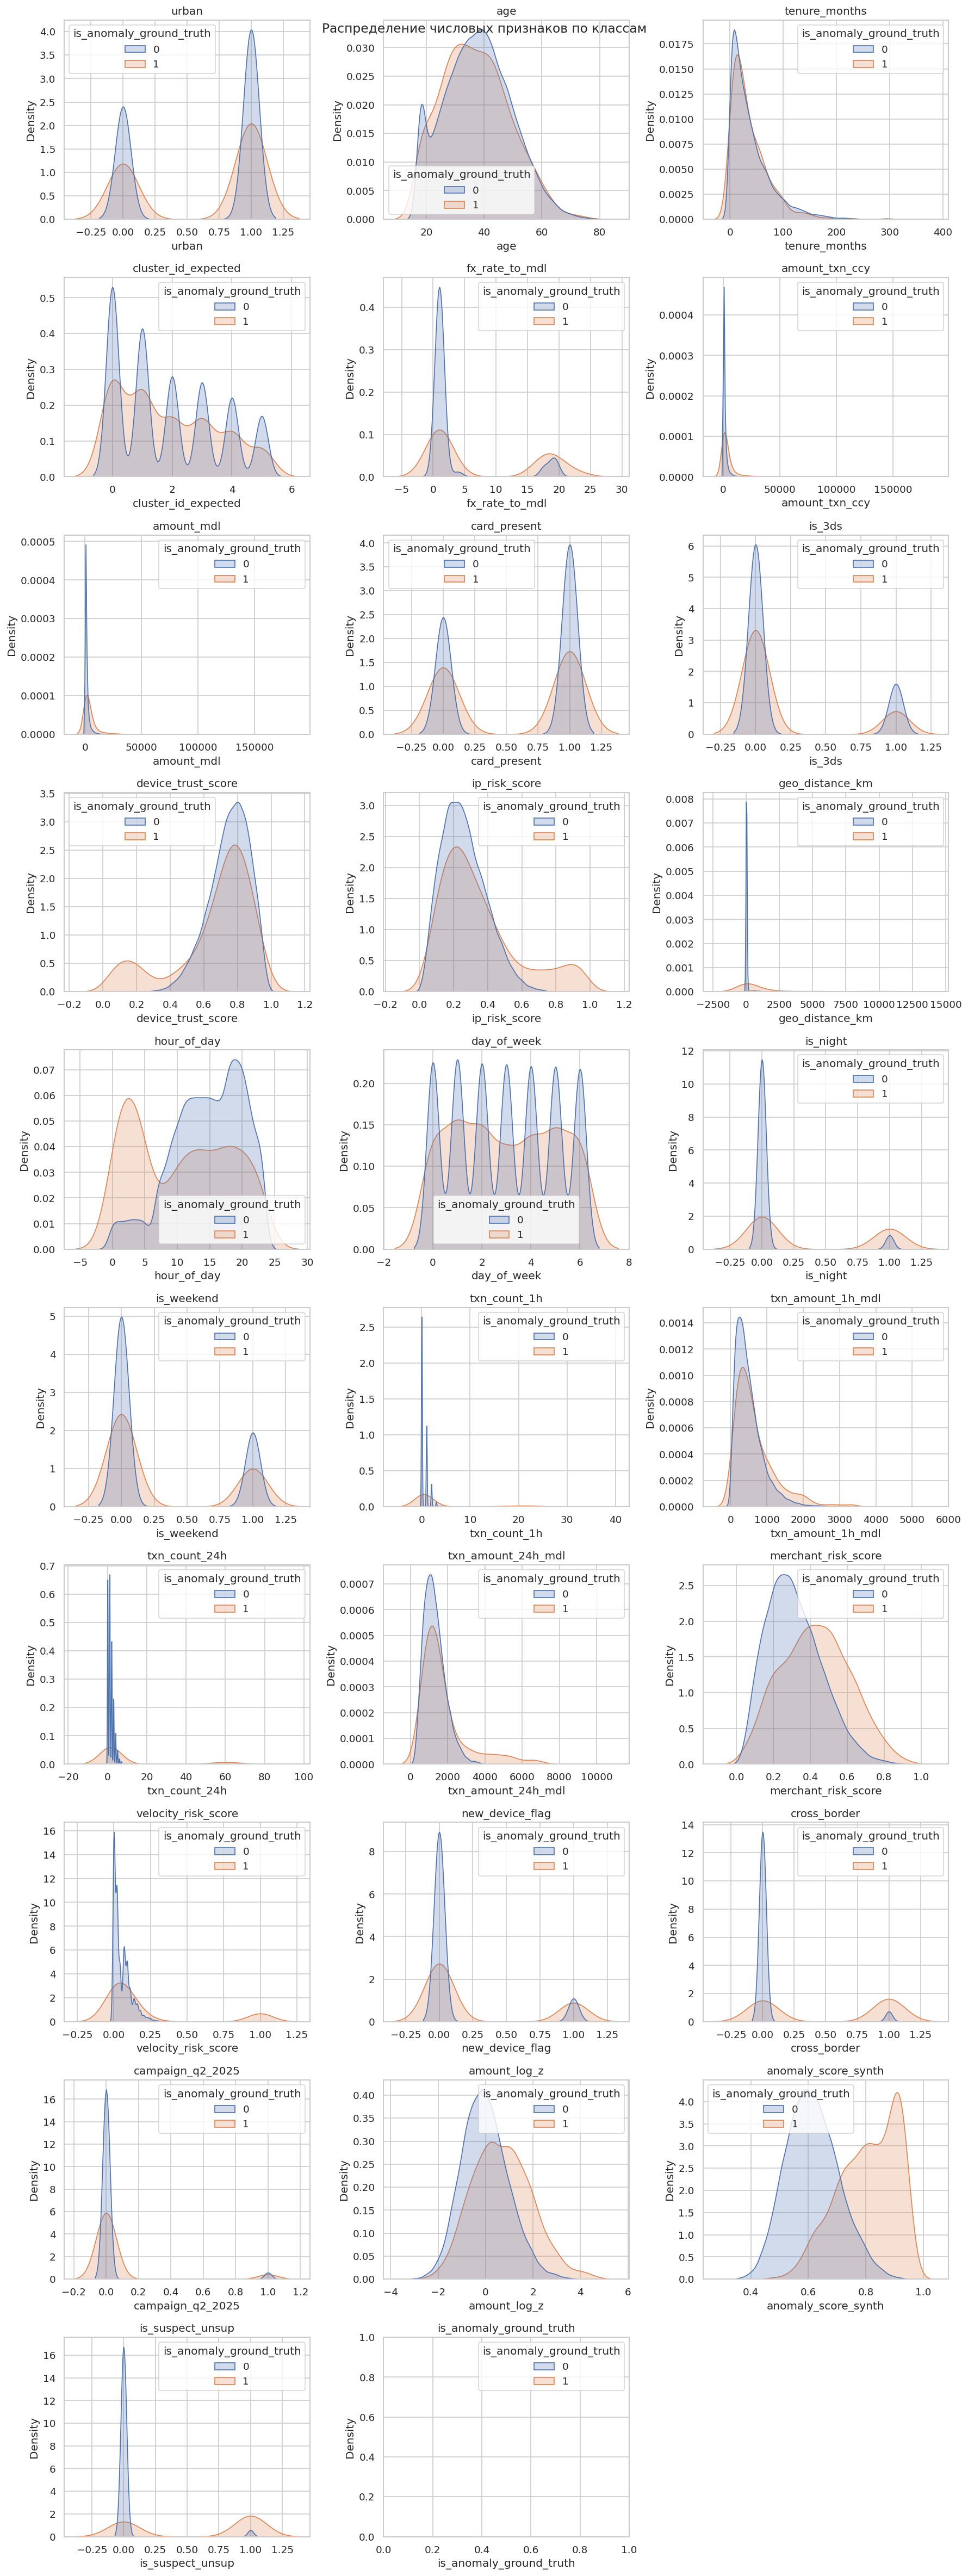

<Figure size 720x480 with 0 Axes>

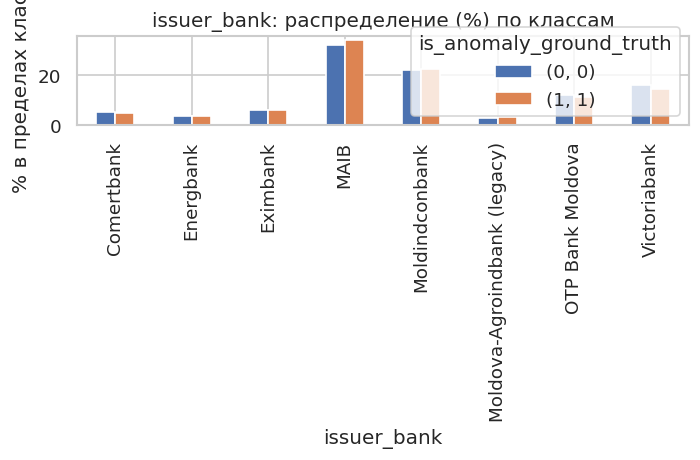

<Figure size 720x480 with 0 Axes>

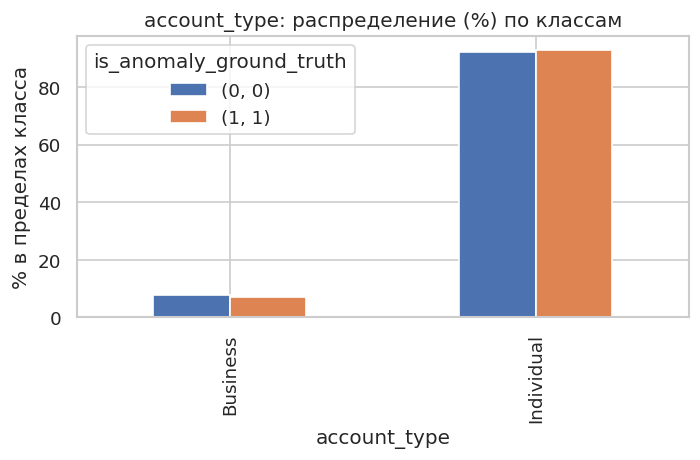

<Figure size 720x480 with 0 Axes>

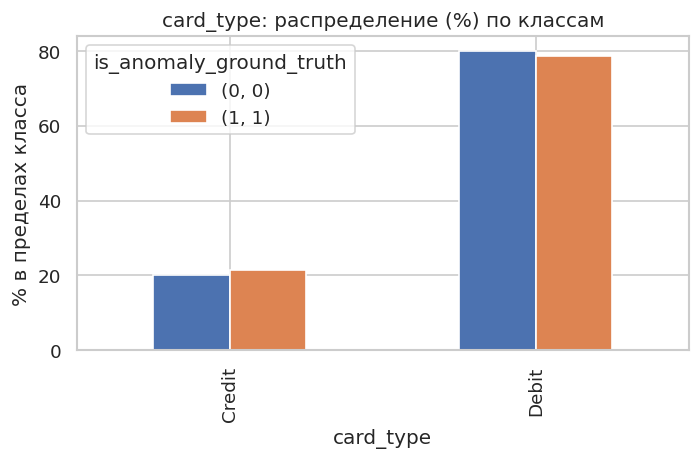

<Figure size 720x480 with 0 Axes>

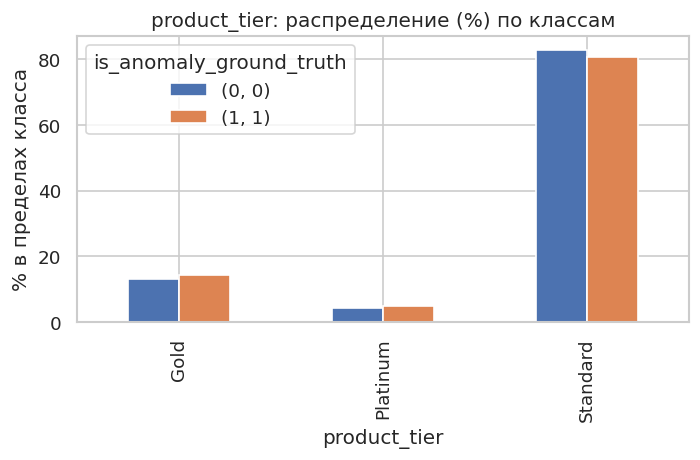

<Figure size 720x480 with 0 Axes>

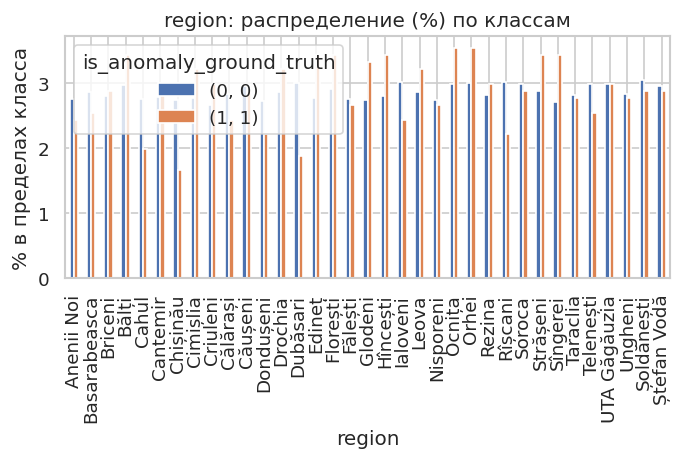

<Figure size 720x480 with 0 Axes>

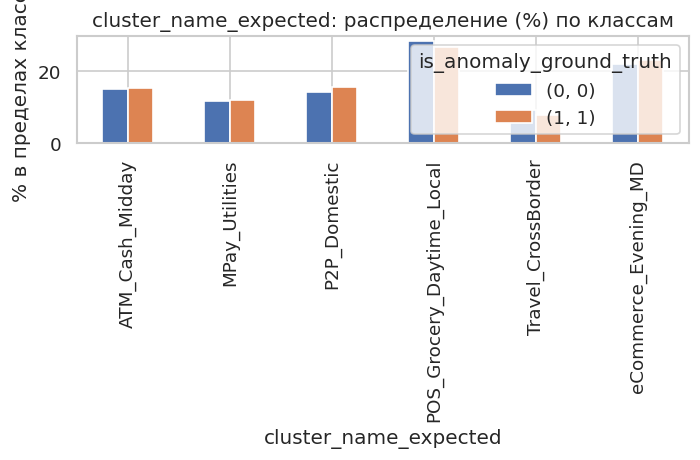

<Figure size 720x480 with 0 Axes>

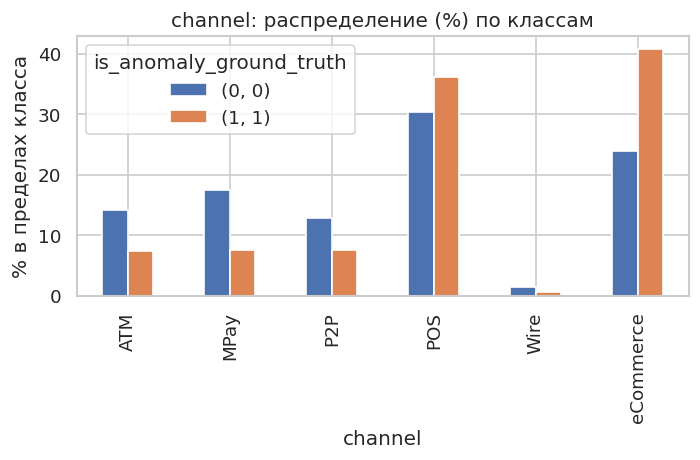

<Figure size 720x480 with 0 Axes>

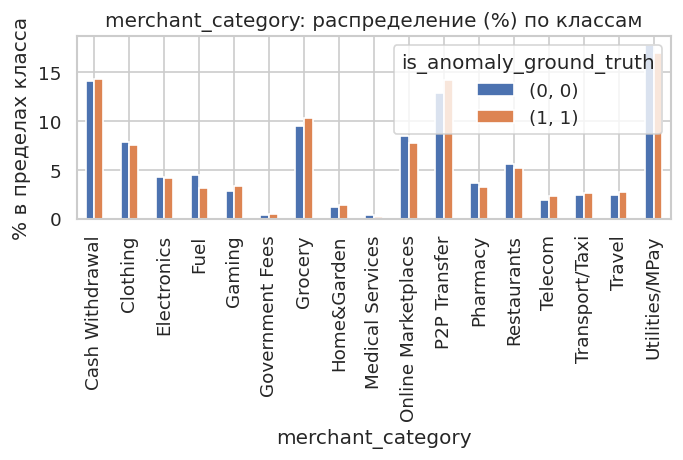

<Figure size 720x480 with 0 Axes>

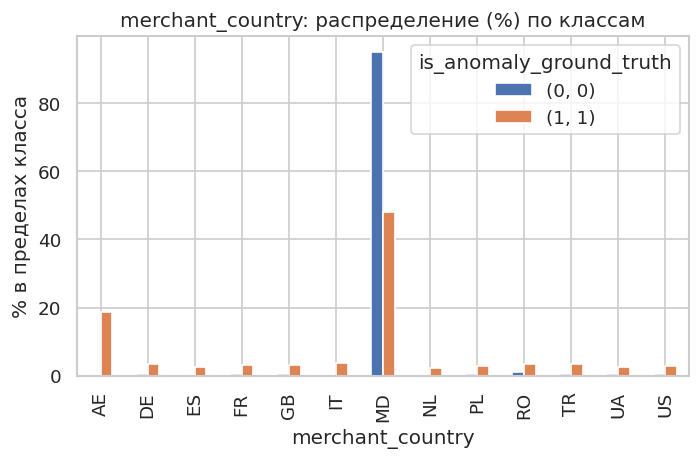

<Figure size 720x480 with 0 Axes>

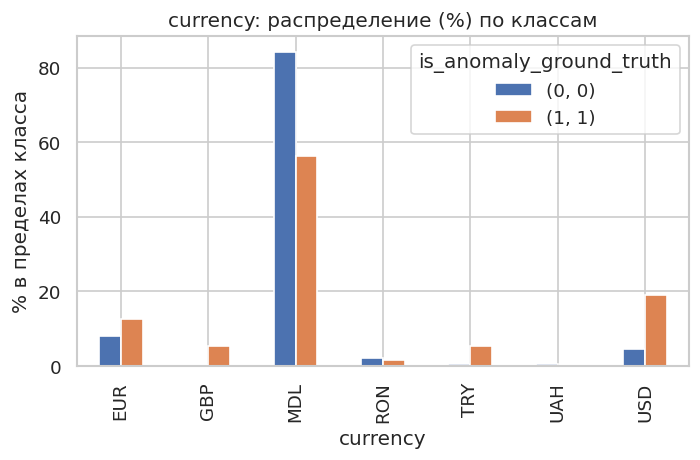

<Figure size 720x480 with 0 Axes>

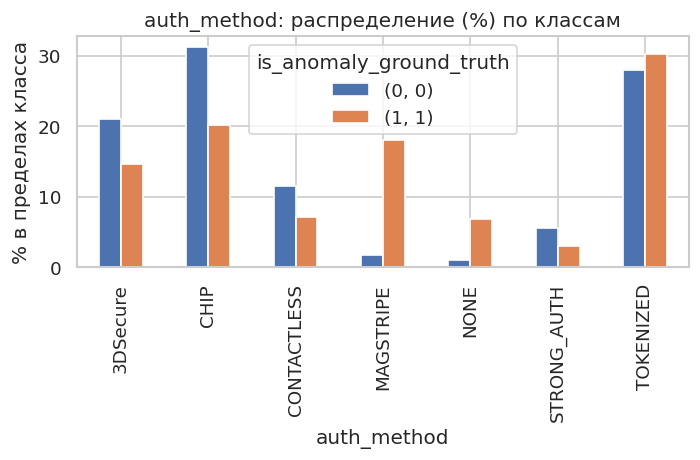

<Figure size 720x480 with 0 Axes>

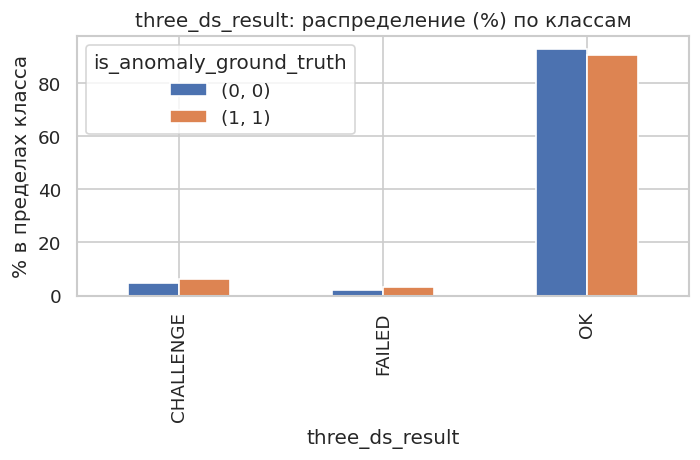

<Figure size 720x480 with 0 Axes>

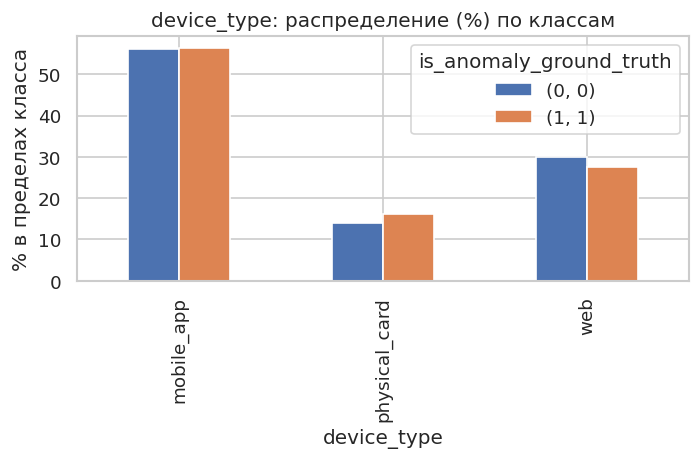

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Датасет
CSV_PATH = 'moldova_payments_suspicious.csv'

df = auto_read_csv(CSV_PATH)
print("Колонки:", list(df.columns)[:20], "...")
display(df.head(3))

# === Настройки отображения ===
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# === Убедимся, что метка в данных ===
assert 'is_anomaly_ground_truth' in df.columns, "Нет колонки is_anomaly_ground_truth"

# === Список признаков (можно ограничить до топ-N) ===
features = [col for col in df.columns if col not in ['transaction_id', 'timestamp', 'customer_id', 'anomaly_type']]

# === Определяем числовые и категориальные признаки ===
num_cols = [col for col in features if pd.api.types.is_numeric_dtype(df[col])]
cat_cols = [col for col in features if not pd.api.types.is_numeric_dtype(df[col])]

print(f"Числовых признаков: {len(num_cols)}, категориальных: {len(cat_cols)}")


# === 1. Числовые признаки — boxplot/kde ===
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=df, x=col, hue='is_anomaly_ground_truth', ax=axes[i], fill=True, common_norm=False, legend = 1)
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Распределение числовых признаков по классам", fontsize=14)
plt.tight_layout()
plt.show()

# === 2. Категориальные признаки — процентные соотношения ===
for col in cat_cols:
    plt.figure(figsize=(6,4))
    dist = (df.groupby(['is_anomaly_ground_truth', col])
                 .size()
                 .groupby(level=0)
                 .apply(lambda x: 100 * x / x.sum())
                 .unstack()
                 .fillna(0))
    dist.T.plot(kind='bar', figsize=(6,4))
    plt.title(f"{col}: распределение (%) по классам")
    plt.ylabel("% в пределах класса")
    plt.xlabel(col)
    plt.legend(title="is_anomaly_ground_truth")
    plt.tight_layout()
    plt.show()

Оставляем колонки
- device_trust_score,
- ip_risk_score,
- geo_distance_km,
- hour_of_day,
- is_night,
- txn_count_1h,
- txn_amount_1h_mdl,
- txn_count_24h,
- txn_amount_24h_mdl,
- merchant_risk_score,
- velocity_risk_score,
- new_device_flag,
- cross_border,
- channel,
- merchant_country,
- currency,
- auth_method

In [7]:
y_bin, y_cat_rule = build_targets(df)

# Готовим X

# drop_cols = [
#     'transaction_id', 'timestamp', 'customer_id',
#     'is_anomaly_ground_truth', 'anomaly_type',
#     'is_suspect_unsup', 'anomaly_score_synth',
#     'cluster_id_expected', 'amount_txn_ccy',
# ]
# X_all = df_encoded.drop(columns=[c for c in drop_cols if c in df_encoded.columns], errors='ignore')


cols_to_keep = ['device_trust_score', 'ip_risk_score', 'geo_distance_km', 'hour_of_day', 'is_night', 'txn_count_1h', 'txn_amount_1h_mdl', 'txn_count_24h', 'txn_amount_24h_mdl', 'merchant_risk_score', 'velocity_risk_score', 'new_device_flag', 'cross_border', 'channel', 'merchant_country', 'currency', 'auth_method']
X_all = df.drop(columns=[c for c in df.columns if c not in cols_to_keep])
X_all = encode_features(X_all)


# Сплит
train_idx, test_idx = time_or_random_split(df, X_all, y_bin, test_size=0.2)
X_train = X_all.iloc[train_idx].reset_index(drop=True)
X_test  = X_all.iloc[test_idx].reset_index(drop=True)
y_train = y_bin.iloc[train_idx].reset_index(drop=True)
y_test  = y_bin.iloc[test_idx].reset_index(drop=True)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print("Target distribution (train):")
print(y_train.value_counts(normalize=True).round(3))


Разделитель ';' -> форма (30000, 1)
Разделитель ',' -> форма (30000, 46)
Разделитель '	' -> форма (30000, 1)
Разделитель '|' -> форма (30000, 1)
Данные загружены: (30000, 46)
Колонки: ['transaction_id', 'timestamp', 'customer_id', 'issuer_bank', 'account_type', 'card_type', 'product_tier', 'region', 'urban', 'age', 'tenure_months', 'cluster_id_expected', 'cluster_name_expected', 'channel', 'merchant_category', 'merchant_country', 'currency', 'fx_rate_to_mdl', 'amount_txn_ccy', 'amount_mdl'] ...


,transaction_id,timestamp,customer_id,issuer_bank,account_type,card_type,product_tier,region,urban,age,...,merchant_risk_score,velocity_risk_score,new_device_flag,cross_border,campaign_q2_2025,amount_log_z,anomaly_score_synth,is_suspect_unsup,is_anomaly_ground_truth,anomaly_type
0,TX900000,2025-02-02 21:50:55,CUST350000,MAIB,Individual,Credit,Standard,Hîncești,1,50,...,0.566,0.16,0,0,0,-0.840,0.5603,0,0,NORMAL
1,TX900001,2025-08-23 22:21:25,CUST350001,Comertbank,Individual,Debit,Standard,Edineț,1,37,...,0.263,0.06,0,0,0,1.289,0.6702,0,0,NORMAL
2,TX900002,2024-01-15 08:14:16,CUST350002,Energbank,Individual,Debit,Standard,Ștefan Vodă,1,27,...,0.307,0.32,0,0,0,0.782,0.6722,0,0,NORMAL


Классы (rule): ['ECOM_NIGHT_NO3DS_HIGHAMT', 'IMPOSSIBLE_TRAVEL', 'NEW_DEVICE_IP_CROSS', 'NORMAL', 'POS_MAGSTRIPE_NIGHT', 'RARE_COUNTRY_CCY', 'VELOCITY_BURST']
После энкодинга: (30000, 46)
Разделение по времени: 24000 train / 6000 test (80.0% train)
Train: (24000, 46), Test: (6000, 46)
Target distribution (train):
is_anomaly_ground_truth
0    0.97
1    0.03
Name: proportion, dtype: float64


### 4.1) LightGBM - Supervised Model. Она использует свои древовидные и градиентно-бустинговые механизмы, чтобы классифицировать объекты как нормальные или аномальные.


[LightGBM] [Info] Number of positive: 724, number of negative: 23276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1719
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030167 -> initscore=-3.470387
[LightGBM] [Info] Start training from score -3.470387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

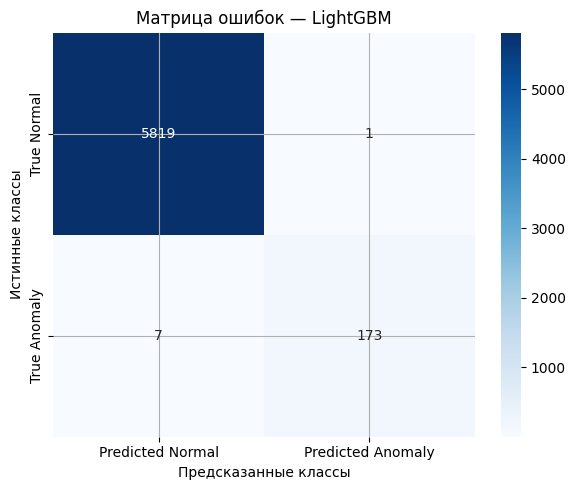

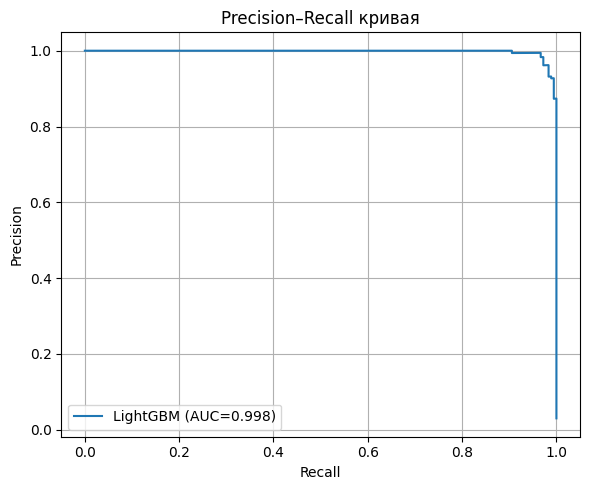

In [8]:
# LightGBM
lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE
)
lgbm.fit(X_train, y_train)

y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
y_pred_lgbm = (y_proba_lgbm >= 0.5).astype(int)

metrics_lgbm = evaluate_and_print(y_test, y_pred_lgbm, y_proba_lgbm, "LightGBM")
plot_confusion_matrix(y_test, y_pred_lgbm, "Матрица ошибок — LightGBM")
pr_auc_lgbm = plot_pr_curve(y_test, y_proba_lgbm, "LightGBM")


### 4.2) Random Forest - Supervised Model. Она строит много независимых деревьев решений и объединяет их прогнозы. Она снижает переобучение за счёт случайного отбора признаков и выборок, устойчива к шуму.


Оценка качества: Random Forest
Accuracy:  0.9983
Precision: 0.9942
Recall:    0.9500
F1-score:  0.9716
ROC-AUC:   0.9999
PR-AUC:    0.9972

Classification report:
              precision    recall  f1-score   support

           0     0.9985    0.9998    0.9991      5820
           1     0.9942    0.9500    0.9716       180

    accuracy                         0.9983      6000
   macro avg     0.9963    0.9749    0.9854      6000
weighted avg     0.9983    0.9983    0.9983      6000



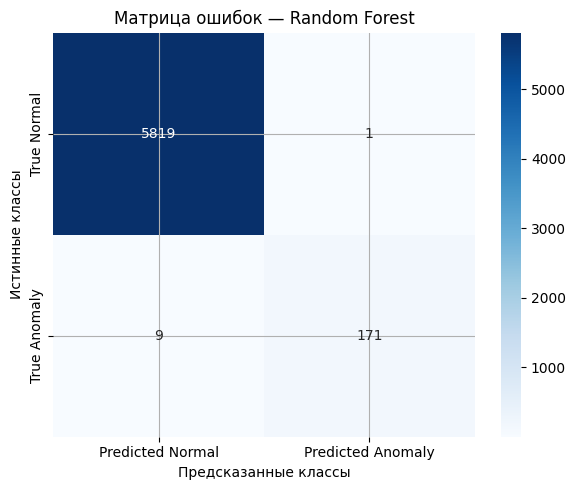

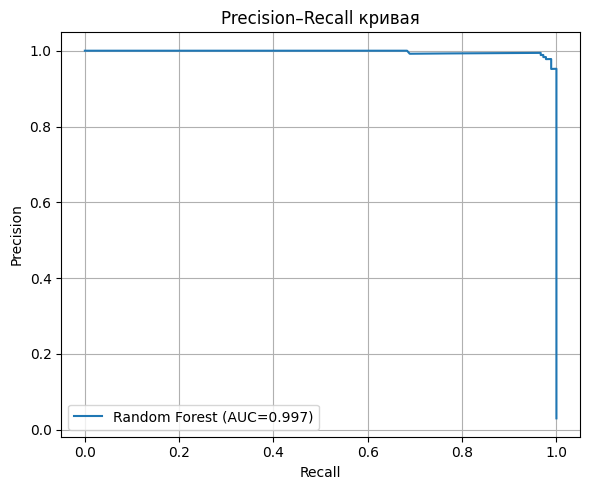

In [9]:
# Random Forest

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

metrics_rf = evaluate_and_print(y_test, y_pred_rf, y_proba_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_rf, "Матрица ошибок — Random Forest")
pr_auc_rf = plot_pr_curve(y_test, y_proba_rf, "Random Forest")


### 4.3) Isolation Forest - Semi-supervised Model. Метод, который ищет аномалии, изолируя точки данных с помощью множества случайных деревьев. Аномальные объекты изолируются быстрее, потому что они отличаются от основной массы,


Оценка качества: Isolation Forest
Accuracy:  0.9623
Precision: 0.3873
Recall:    0.4389
F1-score:  0.4115
ROC-AUC:   0.9478
PR-AUC:    0.3422

Classification report:
              precision    recall  f1-score   support

           0     0.9826    0.9785    0.9805      5820
           1     0.3873    0.4389    0.4115       180

    accuracy                         0.9623      6000
   macro avg     0.6849    0.7087    0.6960      6000
weighted avg     0.9647    0.9623    0.9635      6000



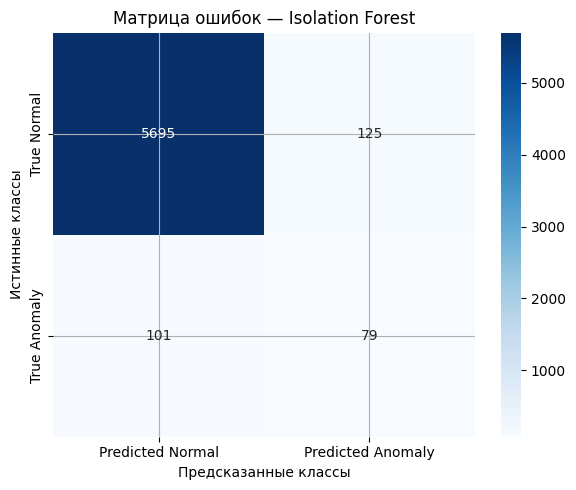

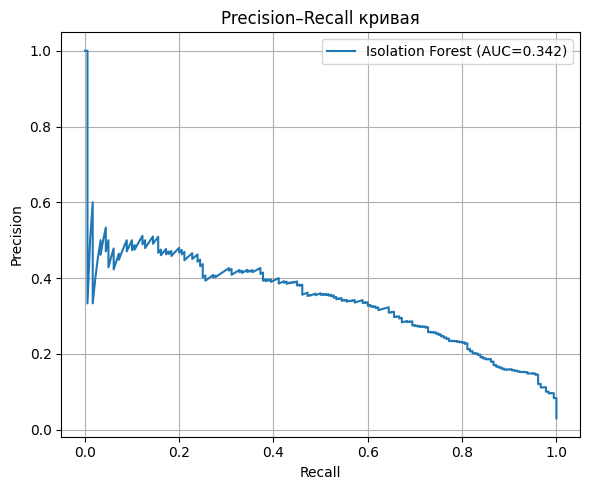

In [10]:
# Isolation Forest
iso = IsolationForest(
    n_estimators=200,
    contamination=CONTAMINATION,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

iso.fit(X_train)
# predict возвращает 1 (нормальные), -1 (аномалии)
y_pred_iso = iso.predict(X_test)
y_pred_iso_bin = (y_pred_iso == -1).astype(int)
scores_iso = -iso.decision_function(X_test)

metrics_iso = evaluate_and_print(y_test, y_pred_iso_bin, scores_iso, "Isolation Forest")
plot_confusion_matrix(y_test, y_pred_iso_bin, "Матрица ошибок — Isolation Forest")
pr_auc_iso = plot_pr_curve(y_test, scores_iso, "Isolation Forest")


### Проводим нормализацию для основанных на расстоянии моделей

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.4) DBSCAN - Unsupervised Model. Алгоритм кластеризации на основе плотности, который группирует точки, находящиеся близко друг к другу, и помечает изолированные точки как аномалии. Он не требует заранее задавать число кластеров.


Оценка качества: DBSCAN
Accuracy:  0.9675
Precision: 0.3077
Recall:    0.0667
F1-score:  0.1096
ROC-AUC:   0.5310
PR-AUC:    0.2012

Classification report:
              precision    recall  f1-score   support

           0     0.9718    0.9954    0.9834      5820
           1     0.3077    0.0667    0.1096       180

    accuracy                         0.9675      6000
   macro avg     0.6398    0.5310    0.5465      6000
weighted avg     0.9519    0.9675    0.9572      6000



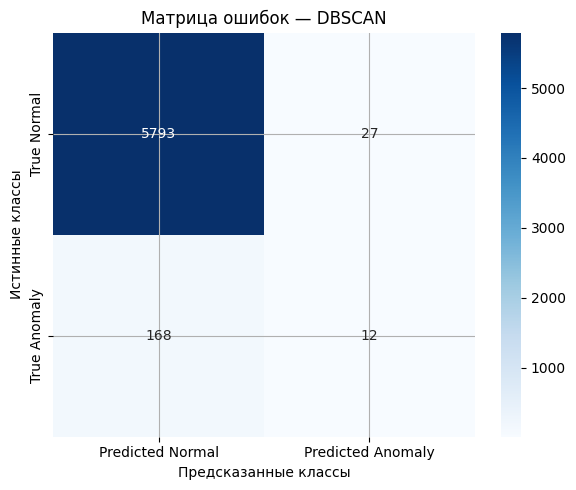

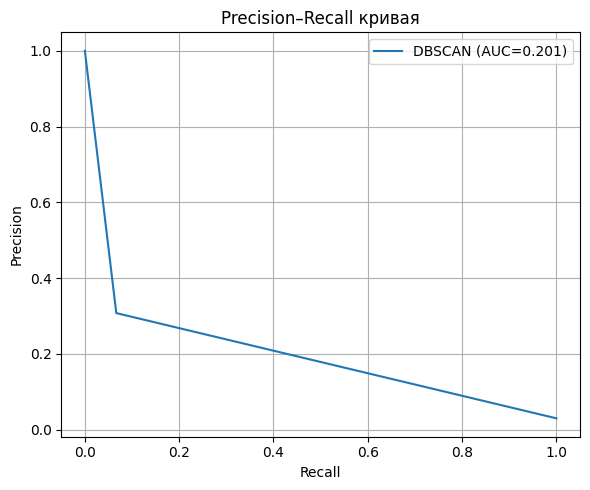

In [12]:
# DBSCAN не даёт вероятностей. Используем бинаризацию: -1 -> аномалия.
dbscan = DBSCAN(eps=10, min_samples=5, n_jobs=-1)
dbscan.fit(X_test_scaled)
dbscan_labels = dbscan.labels_
y_pred_dbscan = (dbscan_labels == -1).astype(int)

# Для ROC-AUC/PR используем: 1 для -1 (аномалия), 0 иначе
scores_dbscan = (dbscan_labels == -1).astype(int)

metrics_dbscan = evaluate_and_print(y_test, y_pred_dbscan, scores_dbscan, "DBSCAN")
plot_confusion_matrix(y_test, y_pred_dbscan, "Матрица ошибок — DBSCAN")
pr_auc_dbscan = plot_pr_curve(y_test, scores_dbscan, "DBSCAN")



### 4.5) Local Outlier Factor - Unsupervised Model. LOF — это алгоритм, который оценивает степень аномальности точки, сравнивая её локальную плотность с плотностью соседей. Объекты с заметно меньшей плотностью считаются выбросами.


Оценка качества: Local Outlier Factor (novelty=True)
Accuracy:  0.9542
Precision: 0.2346
Recall:    0.2333
F1-score:  0.2340
ROC-AUC:   0.8967
PR-AUC:    0.1769

Classification report:
              precision    recall  f1-score   support

           0     0.9763    0.9765    0.9764      5820
           1     0.2346    0.2333    0.2340       180

    accuracy                         0.9542      6000
   macro avg     0.6055    0.6049    0.6052      6000
weighted avg     0.9540    0.9542    0.9541      6000



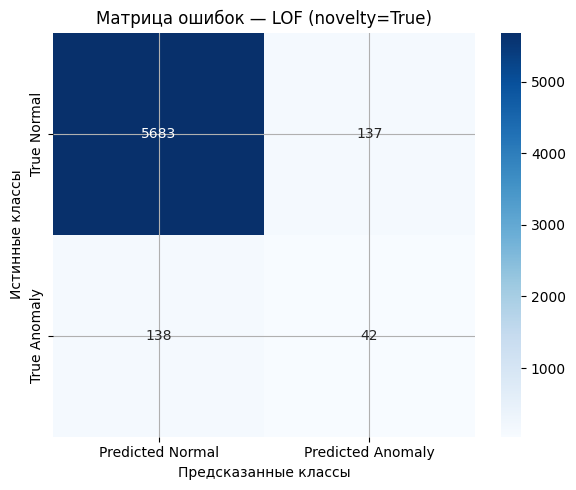

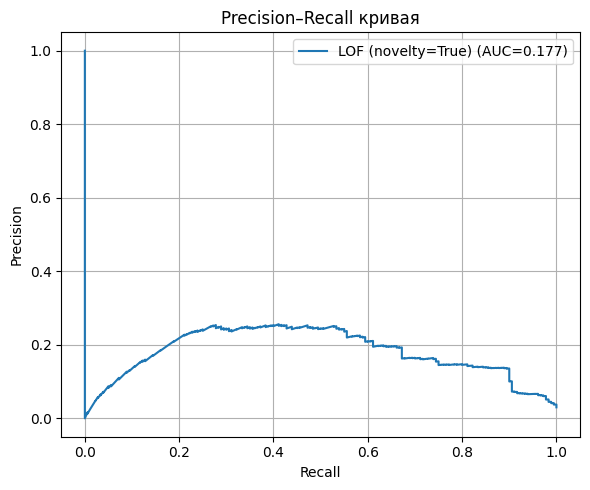

In [13]:
# LOF
lof = LocalOutlierFactor(
    n_neighbors=200,
    contamination=CONTAMINATION,
    novelty=True
)

lof.fit(X_train_scaled)

y_pred_lof = lof.predict(X_test_scaled)
y_pred_lof_bin = (y_pred_lof == -1).astype(int)

scores_lof = -lof.score_samples(X_test_scaled)

scores_lof = (scores_lof - scores_lof.min()) / (scores_lof.max() - scores_lof.min() + 1e-9)

metrics_lof = evaluate_and_print(y_test, y_pred_lof_bin, scores_lof, "Local Outlier Factor (novelty=True)")
plot_confusion_matrix(y_test, y_pred_lof_bin, "Матрица ошибок — LOF (novelty=True)")
pr_auc_lof = plot_pr_curve(y_test, scores_lof, "LOF (novelty=True)")


### 4.6) Gaussian Mixture Model - Unsupervised Model. GMM — это вероятностная модель, которая представляет данные как смесь нескольких нормальных распределений. Точки с низкой вероятностью принадлежности к любому из распределений считаются аномалиями.


Оценка качества: GMM
Accuracy:  0.9657
Precision: 0.4278
Recall:    0.4278
F1-score:  0.4278
ROC-AUC:   0.8669
PR-AUC:    0.2893

Classification report:
              precision    recall  f1-score   support

           0     0.9823    0.9823    0.9823      5820
           1     0.4278    0.4278    0.4278       180

    accuracy                         0.9657      6000
   macro avg     0.7050    0.7050    0.7050      6000
weighted avg     0.9657    0.9657    0.9657      6000



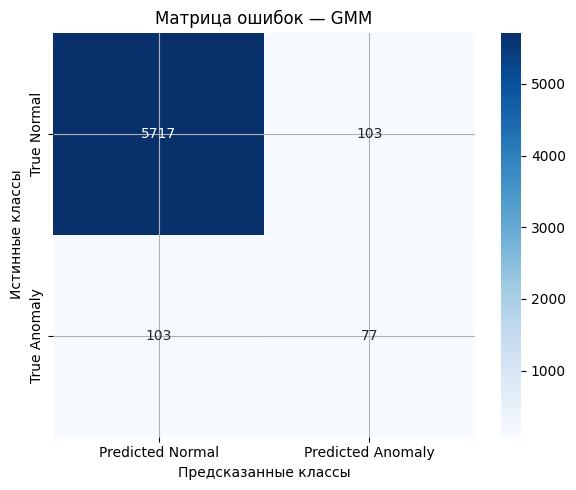

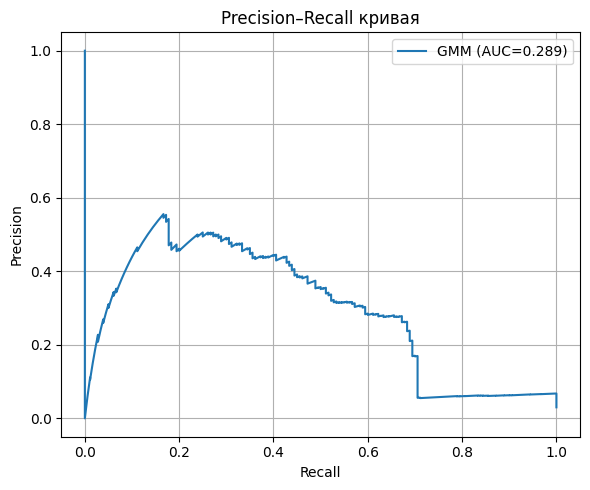

In [14]:
# GMM
gmm = GaussianMixture(
    n_components=2,
    covariance_type='full',
    random_state=RANDOM_STATE
)
gmm.fit(X_train_scaled)

anomaly_scores_gmm = -gmm.score_samples(X_test_scaled)

thr_gmm = np.percentile(anomaly_scores_gmm, (1 - CONTAMINATION) * 100)
y_pred_gmm = (anomaly_scores_gmm > thr_gmm).astype(int)

metrics_gmm = evaluate_and_print(y_test, y_pred_gmm, anomaly_scores_gmm, "GMM")
plot_confusion_matrix(y_test, y_pred_gmm, "Матрица ошибок — GMM")
pr_auc_gmm = plot_pr_curve(y_test, anomaly_scores_gmm, "GMM")


### 4.7) Histogram Based Outlier Score - Unsupervised Model. HBOS — это метод на основе гистограмм, который оценивает плотность значений каждого признака отдельно. Объекты с низкой совокупной плотностью считаются аномалиями.


Оценка качества: HBOS
Accuracy:  0.9577
Precision: 0.3221
Recall:    0.3722
F1-score:  0.3454
ROC-AUC:   0.9210
PR-AUC:    0.2901

Classification report:
              precision    recall  f1-score   support

           0     0.9805    0.9758    0.9781      5820
           1     0.3221    0.3722    0.3454       180

    accuracy                         0.9577      6000
   macro avg     0.6513    0.6740    0.6617      6000
weighted avg     0.9607    0.9577    0.9591      6000



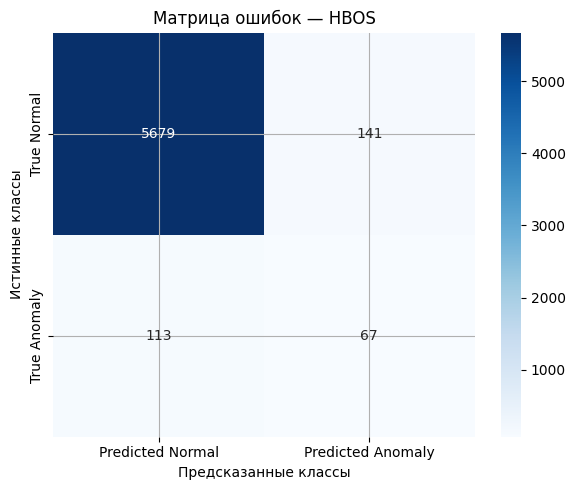

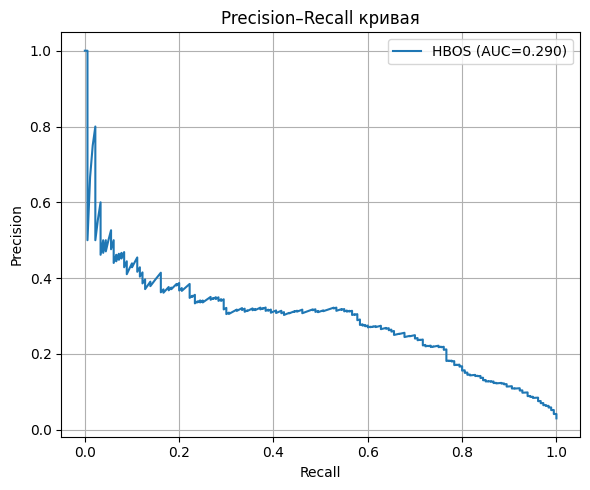

In [15]:
# HBOS
hbos = HBOS(contamination=CONTAMINATION)
hbos.fit(X_train_scaled)

y_pred_hbos = hbos.predict(X_test_scaled)
scores_hbos = hbos.decision_function(X_test_scaled)

metrics_hbos = evaluate_and_print(y_test, y_pred_hbos, scores_hbos, "HBOS")
plot_confusion_matrix(y_test, y_pred_hbos, "Матрица ошибок — HBOS")
pr_auc_hbos = plot_pr_curve(y_test, scores_hbos, "HBOS")

### 4.8) One Class Support Vector Machine - Semi-Supervised. Вариант метода опорных векторов, который обучается только на нормальных данных и ищет границу, отделяющую их от возможных аномалий. Точки, выходящие за эту границу, считаются выбросами.


Оценка качества: One-Class SVM (trained on normals only)
Accuracy:  0.9585
Precision: 0.4127
Recall:    0.9056
F1-score:  0.5670
ROC-AUC:   0.9883
PR-AUC:    0.7406

Classification report:
              precision    recall  f1-score   support

           0     0.9970    0.9601    0.9782      5820
           1     0.4127    0.9056    0.5670       180

    accuracy                         0.9585      6000
   macro avg     0.7048    0.9328    0.7726      6000
weighted avg     0.9794    0.9585    0.9659      6000



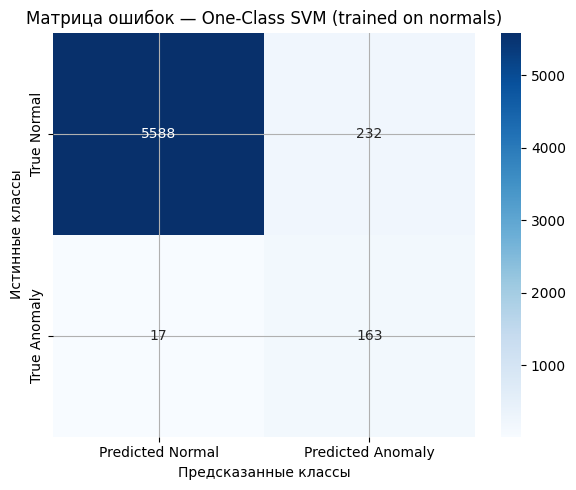

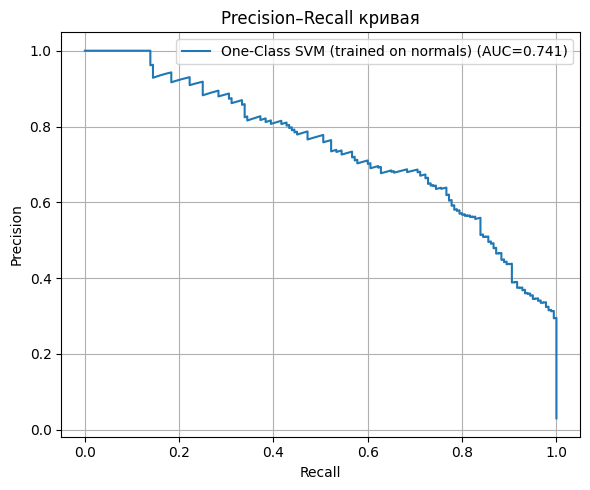

In [16]:
# Фильтруем только нормальные данные для обучения
X_train_normals = X_train_scaled[y_train == 0]

# Обучаем только на нормальных
ocsvm = OneClassSVM(kernel='rbf', nu=CONTAMINATION, gamma='scale')
ocsvm.fit(X_train_normals)

# Предсказываем на тесте
y_pred_ocsvm = (ocsvm.predict(X_test_scaled) == -1).astype(int)
scores_ocsvm = -ocsvm.decision_function(X_test_scaled)

# Оцениваем результаты
metrics_ocsvm = evaluate_and_print(y_test, y_pred_ocsvm, scores_ocsvm, "One-Class SVM (trained on normals only)")
plot_confusion_matrix(y_test, y_pred_ocsvm, "Матрица ошибок — One-Class SVM (trained on normals)")
pr_auc_ocsvm = plot_pr_curve(y_test, scores_ocsvm, "One-Class SVM (trained on normals)")



### 5) Сравнение метрик моделей

In [17]:
summary = pd.DataFrame([
    {"model": "LightGBM",         **metrics_lgbm,  "pr_auc": pr_auc_lgbm},
    {"model": "RandomForest",     **metrics_rf,    "pr_auc": pr_auc_rf},
    {"model": "DBSCAN",           **metrics_dbscan,"pr_auc": pr_auc_dbscan},
    {"model": "LOF",              **metrics_lof,   "pr_auc": pr_auc_lof},
    {"model": "IsolationForest",  **metrics_iso,   "pr_auc": pr_auc_iso},
    {"model": "GMM",              **metrics_gmm,   "pr_auc": pr_auc_gmm},
    {"model": "HBOS",             **metrics_hbos,  "pr_auc": pr_auc_hbos},
    {"model": "OC-SVM",           **metrics_ocsvm, "pr_auc": pr_auc_ocsvm},

]).set_index("model").round(4)

print("Сводка метрик (тест):")
display(summary.sort_values(by=["f1","roc_auc","pr_auc"], ascending=False))

Сводка метрик (тест):


,accuracy,precision,recall,f1,roc_auc,pr_auc
model,,,,,,
LightGBM,0.9987,0.9943,0.9611,0.9774,0.9999,0.9976
RandomForest,0.9983,0.9942,0.9500,0.9716,0.9999,0.9972
OC-SVM,0.9585,0.4127,0.9056,0.5670,0.9883,0.7406
GMM,0.9657,0.4278,0.4278,0.4278,0.8669,0.2893
IsolationForest,0.9623,0.3873,0.4389,0.4115,0.9478,0.3422
HBOS,0.9577,0.3221,0.3722,0.3454,0.9210,0.2901
LOF,0.9542,0.2346,0.2333,0.2340,0.8967,0.1769
DBSCAN,0.9675,0.3077,0.0667,0.1096,0.5310,0.2012


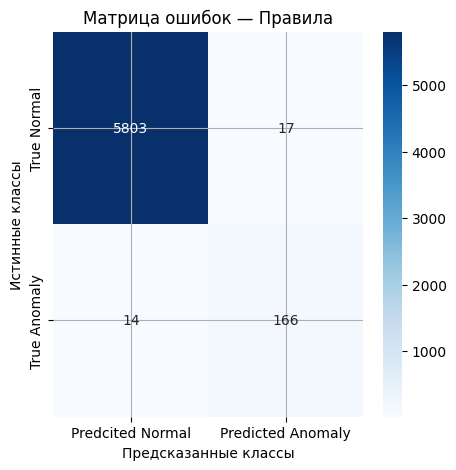

Качество rule-based логики:
Precision: 0.9071
Recall   : 0.9222
F1-score : 0.9146


In [18]:
# Rules

df_test_rules = df.iloc[test_idx].copy()
df_test_rules['rule_category'] = df_test_rules.apply(rule_category, axis=1)
df_test_rules['rule_label'] = (df_test_rules['rule_category'] != 'NORMAL').astype(int)

y_true = y_test.values
y_pred_rule = df_test_rules['rule_label'].values

cm_rules = confusion_matrix(y_true, y_pred_rule)
plt.figure(figsize=(5, 5))
sns.heatmap(
    cm_rules,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Predcited Normal', 'Predicted Anomaly'],
    yticklabels=['True Normal', 'True Anomaly']
)
plt.title("Матрица ошибок — Правила")
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.show()

precision_rule = precision_score(y_true, y_pred_rule, zero_division=0)
recall_rule = recall_score(y_true, y_pred_rule, zero_division=0)
f1_rule = f1_score(y_true, y_pred_rule, zero_division=0)

print("Качество rule-based логики:")
print(f"Precision: {precision_rule:.4f}")
print(f"Recall   : {recall_rule:.4f}")
print(f"F1-score : {f1_rule:.4f}")


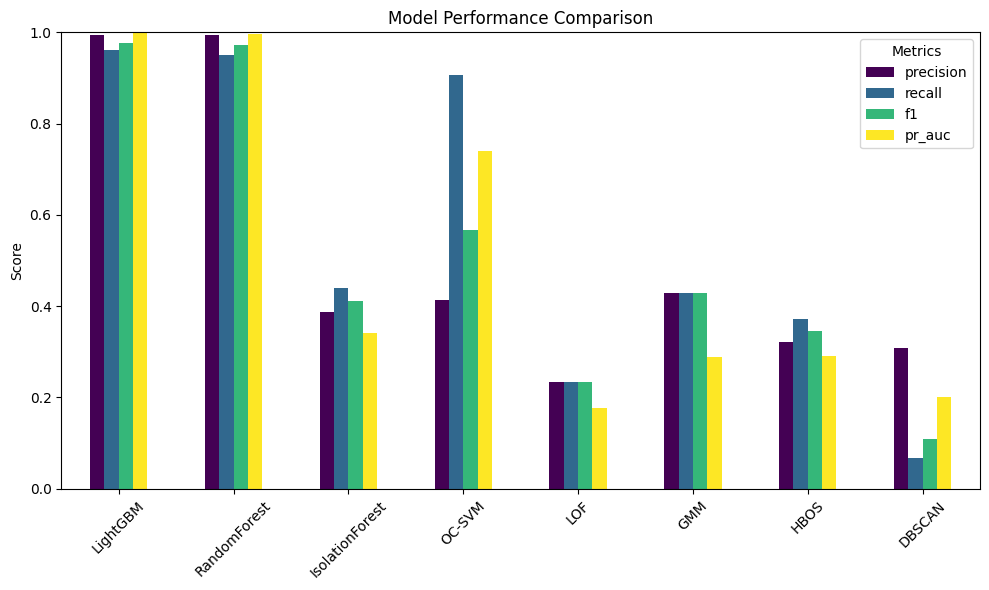

In [19]:

# Сводим все метрики в один словарь
results = {
    'LightGBM': metrics_lgbm,
    'RandomForest': metrics_rf,
    'IsolationForest': metrics_iso,
    'OC-SVM': metrics_ocsvm,
    'LOF': metrics_lof,
    'GMM': metrics_gmm,
    'HBOS': metrics_hbos,
    'DBSCAN': metrics_dbscan
}

# Переводим в DataFrame
df_results = pd.DataFrame(results).T  # транспонируем, чтобы модели были строками

# Строим график
df_results[['precision', 'recall', 'f1', 'pr_auc']].plot(
    kind='bar',
    figsize=(10, 6),
    grid=False,
    rot=45,
    title='Model Performance Comparison',
    colormap='viridis'
)

plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()
